In [1]:
!pip install transformers
!pip install datasets #데이터 세트 다운로드 Hugging Face 연동

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.4 MB/s eta 0:00:00


In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [3]:
import copy # 특정한 파이썬 객체를 통째로 메모리에 copy할 때
import json # json 형식으로 데이터를 표현할 때
import logging # 학습 과정 등 전반적인 프로그램의 진행 상황을 로깅할 때
import os # 파일 입출력 등 현재 컴퓨터에 대한 기능 수행할 때

# 경고(warning) 메시지가 너무 많이 나오는 것을 대비하여 무시 처리
import warnings
warnings.filterwarnings("ignore")

# 로깅할 때 기본적으로 오류(error) 사항으로 로그 메시지를 남기겠다는 의미
import logging
logging.basicConfig(level=logging.ERROR)

# 벡터, 행렬 등의 처리를 위한 NumPy, 테이블(엑셀) 형식의 데이터 처리할 때 Pandas
import numpy as np
import pandas as pd

from datasets import load_dataset
# train_test_split: 별도로 구분된 validation 세트가 없을 때
# 학습 데이터 세트에서 일부를 train과 validation으로 나눌 때 자주 사용 (8:2 정도로 나눔)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch

### 학습한 모델 관련 라이브러리 불러오기

In [4]:
import transformers
# Auto Model For Sequence Classification: 텍스트 분류를 위한 모델 → Cross-Entropy loss 사용
from transformers import AutoConfig, AutoModel, AutoModelForSequenceClassification, AutoTokenizer
# linear_schedule_with_warmup: 단계적으로 learning rate 줄여나가는 방법
# AdamW: SGD와 같이 optimization 방법 중 하나
from transformers import AdamW, get_linear_schedule_with_warmup

### 우리가 쓸 모델

- KoBigBird를 사용하고, 다음과 같은 형태로 사용 가능
- KoBigBird: BigBird 특유의 sparse attention 사용 (default)

In [5]:
from transformers import AutoModel, AutoTokenizer

# by default its in `block_sparse` mode with num_random_blocks=3, block_size=64
# 이름에서부터 알 수 있듯이 KoBigBird는 BERT 기반의 모델
model = AutoModel.from_pretrained("monologg/kobigbird-bert-base")

# Tokenizer도 마찬가지로 BERT 기반에서 가져온 것을 확인
tokenizer = AutoTokenizer.from_pretrained("monologg/kobigbird-bert-base")
text = "한국어 BigBird 모델을 공개합니다!"
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

Attention type 'block_sparse' is not possible if sequence_length: 12 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


### 실험을 위한 하이퍼 파라미터 설정

In [6]:
# SimpleNamespace는 온점(.)으로 속성의 값을 정의할 수 있도록 해주는 라이브러리
# config.task = "cls"라고 하면, 나중에 print(config.task)했을 때 "cls"라고 출력
from types import SimpleNamespace

config = SimpleNamespace()

config.task = "cls"
config.dataset = "comment"

config.cache_dir = "cache" # 현재 데이터 세트에 대한 단어집 등 현재 task를 위한 임시적인 폴더
config.output_dir = "output" # 최종적인 모델이 저장되고, 결과가 저장되는 폴더

config.use_tpu = False
config.model_name_or_path = "monologg/kobigbird-bert-base" # Model name or path (HuggingFace에서 불러와 사용할 모델 이름)
config.data_dir = "./" # The input data dir ("10000_labeled.csv"가 있는 경로)


config.train_file = "complete_train.csv" # 미리 준비된 학습 데이터 세트 경로
config.test_file = "complete_test.csv" # 미리 준비된 평가 데이터 세트 경로

config.max_seq_length = 1024 # The maximum total input sequence length after tokenization. (최대 토큰 길이)
config.train_batch_size = 4 # Batch size for training. (학습할 때 batch_size)
config.eval_batch_size = 2 # Batch size for evaluation. (평가할 때 batch_size)

config.learning_rate = 3e-5 # The initial learning rate for Adam. (Adam optimizer에서 쓸 learning rate)
config.num_train_epochs = 20 # Total number of training epochs to perform. (전체 학습 epoch 수)

config.num_labels = 5 # 현재 task에서 선호도(1: 극진보, 2: 진보, 3: 중립, 4: 보수, 5: 극보수)의 개수는 5개이므로
# 5 classes multi-class classification 문제로 이해 할 수 있음
config.gradient_accumulation_steps = 2 # Number of updates steps to accumulate before performing a backward/update pass.
# batch_size가 큰 것처럼 처리하기 위해서, backward()를 매 번 수행하지 않고, gradient를 누적(acculmulation)하는 것

config.threads = 4
config.seed = 42 # random seed for initialization

config.do_train = True # Whether to run training.
config.do_eval_during_train = True
config.do_eval = True # Whether to run prediction.

config.do_lower_case = False
config.weight_decay = 0.0 # Weight decay if we apply some.
config.adam_epsilon = 1e-8 # Epsilon for Adam optimizer.
config.max_grad_norm = 1.0 # Max gradient norm.
config.warmup_proportion = 0.0 # Warmup proportion for linear warmup
# BigBird에서는 full attention을 하면, 메모리는 조금 더 소모되지만, 더 정확도가 향상
# config.attention_type = "original_full"

### 학습 데이터 전처리
- 학습 text를 매번 tokenization을 하지 않고, 모델 학습 시작전에 미리 모든 텍스트를 tokenization 한 결과를 저장한다.

In [7]:
# 본 실습에서 사용할 tokenizer 객체 초기화
tokenizer = AutoTokenizer.from_pretrained(config.model_name_or_path, cache_dir=config.cache_dir)

In [8]:
def train_split(config, texts, labels, is_train):
    if is_train:
        x_train, x_val, y_train, y_val = train_test_split(
            texts, labels, test_size=500, random_state=config.seed, stratify=None
        )
        return x_train, y_train, x_val, y_val
    else:
        return texts, labels

In [9]:
import pandas as pd
import os
import json
from sklearn.model_selection import train_test_split

# 데이터 전처리 및 분리 함수
def process_and_split_dataset(config, data_file):
    is_train = True if 'train' in data_file else False

    df = pd.read_csv(data_file)
    df = df.dropna(subset=['title', 'content', 'label2'])

    # "label2" 열 추출
    government = (df["label2"]).astype(int).values.tolist()

    # title과 content를 합쳐서 texts로 표현
    texts = (df["title"].str.replace('\n', ' ') + " " + df["content"].str.replace('\n', ' ')).astype(str).values.tolist()

    # 데이터를 학습 및 검증용으로 분할
    return train_split(config, texts, government, is_train)

def data_pretokenizing(config, tokenizer, mode="train"):
    # 파일 경로 설정
    data_path = os.path.join(config.data_dir, config.train_file if mode == "train" else config.test_file)
    processed_data = process_and_split_dataset(config, data_path)

    datasets = {}
    if mode == "train":
        train_data_texts, train_data_labels, valid_data_texts, valid_data_labels = processed_data
        datasets["train"] = (train_data_texts, train_data_labels)
        datasets["valid"] = (valid_data_texts, valid_data_labels)
    else:  # mode == "test"
        test_data_texts, test_data_labels = processed_data
        datasets["test"] = (test_data_texts, test_data_labels)

    dataset_files = {}
    for key, (texts, labels) in datasets.items():
        # 데이터 파일명 설정
        dataset_file = os.path.join(config.data_dir, f"{config.dataset}_{config.model_name_or_path.replace('/', '_')}_{config.max_seq_length}_{key}_dataset.txt")
        print("dataset_file:", dataset_file)

        with open(dataset_file, "w", encoding="utf-8") as writer_file:
            for text, label in zip(texts, labels):
                print(f"Processing text: {text[:50]}...")  # 첫 50자만 출력
                print(f"Processing label: {label}")

                feature = tokenizer(text, max_length=config.max_seq_length, padding="max_length", truncation=True, add_special_tokens=True)

                writed_data = {
                    "input_ids": feature["input_ids"],
                    "attention_mask": feature["attention_mask"],
                    "government": label  # 'politic'을 'government'로 변경
                }
                writer_file.write(json.dumps(writed_data) + "\n")

        dataset_files[key] = dataset_file

    return dataset_files


In [10]:
# 학습 및 검증 데이터 토큰화
train_valid_files = data_pretokenizing(config, tokenizer=tokenizer, mode="train")
train_dataset_file = train_valid_files["train"]
valid_dataset_file = train_valid_files["valid"]

# 테스트 데이터 토큰화
test_files = data_pretokenizing(config, tokenizer=tokenizer, mode="test")
test_dataset_file = test_files["test"]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Processing text: 돈봉투 의혹' 윤관석·이성만, 당내 압박에 결국 자진탈당 지난 2021년 더불어민주당 전당...
Processing label: 0
Processing text: 노량진 수산시장 상인 “집회꾼들, 같이 시위하자고 계속 전화... 딱 잘라 거절” 2023...
Processing label: 0
Processing text: 김웅 "김재원의 '조상묘 파기'겠죠"…김재원, 5.18묘지 기습 참배에 반응 '싸늘' 김재...
Processing label: 0
Processing text: KBS 노동조합, 남영진 이사장 '청탁금지법 위반' 권익위 고발 KBS 노동조합은 13일 ...
Processing label: 0
Processing text: 내년 5월까지 손묶인 홍준표 "발언권은 살아 있다…내겐 3년의 긴 시간이"         ...
Processing label: 0
Processing text: "9사단 지휘부 16첩 반상 호화파티…사병들 앓아눕기도"         임태훈 군인권센터 ...
Processing label: 2
Processing text: 이번엔 '국회 간첩' 논란…국민의힘 “민주 보좌관 전수조사하라” 설훈 더불어민주당 의원실에...
Processing label: 0
Processing text: 이재명 “환자에 헌신한 故주석중 교수 명복 빈다” 18일 오후 서울아산병원 장례식장에 고 ...
Processing label: 0
Processing text: ‘스토킹 방지법’ 국회 본회의 통과... 피해자가 원하지 않아도 처벌 김진표 국회의장이 2...
Processing label: 0
Processing text: 서복경 혁신위원 "당원 200만, 늘어난 몸집 맞는 시스템 찾는 중"         서복경...
Processing label: 0
Processing text: 국회 윤리특위, '김남국 심사' 1소위 배정…"8월 본회의 상정 원

### 데이터로더 초기화

#### 데이터패딩

In [11]:
class IterableDatasetPad(torch.utils.data.IterableDataset):
    def __init__(
        self,
        dataset: torch.utils.data.IterableDataset,
        batch_size: int = 1,
        num_devices: int = 1,
        seed: int = 0,
    ):
        self.dataset = dataset
        self.batch_size = batch_size
        self.seed = seed
        self.num_examples = 0

        chunk_size = self.batch_size * num_devices
        length = len(dataset)
        self.length = length + (chunk_size - length % chunk_size)

    def __len__(self):
        return self.length

    def __iter__(self):
        self.num_examples = 0
        if (
            not hasattr(self.dataset, "set_epoch")
            and hasattr(self.dataset, "generator")
            and isinstance(self.dataset.generator, torch.Generator)
        ):
            self.dataset.generator.manual_seed(self.seed + self.epoch)

        first_batch = None
        current_batch = []
        for element in self.dataset:
            self.num_examples += 1
            current_batch.append(element)
            # Wait to have a full batch before yielding elements.
            if len(current_batch) == self.batch_size:
                for batch in current_batch:
                    yield batch
                    if first_batch is None:
                        first_batch = batch.copy()
                current_batch = []

        while self.num_examples < self.length:
            add_num = self.batch_size - len(current_batch)
            self.num_examples += add_num
            current_batch += [first_batch] * add_num
            for batch in current_batch:
                yield batch
            current_batch = []

#### 전처리된 데이터를 DataLoader로 불러옴

In [12]:
import torch.utils.data as torch_data

def collate_fn(features):
    input_ids = [sample["input_ids"] for sample in features]
    attention_mask = [sample["attention_mask"] for sample in features]
    government = [sample["government"] for sample in features]  # 'politic'을 'government'로 변경

    input_ids = torch.tensor(np.array(input_ids).astype(np.int64), dtype=torch.long)
    attention_mask = torch.tensor(np.array(attention_mask).astype(np.int8), dtype=torch.long)
    government = torch.tensor(np.array(government).astype(np.int64), dtype=torch.long)  # 'politic'을 'government'로 변경

    inputs = {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
    }
    labels = {
        "government": government  # 'politic'을 'government'로 변경
    }
    return inputs, labels

# 본 코드에서 학습을 수행하려는 경우
if config.do_train:
    # 학습 데이터 로더 초기화
    train_dataset = load_dataset("text", data_files=train_dataset_file, download_mode="force_redownload")["train"]
    train_dataset = train_dataset.map(lambda x: json.loads(x["text"]), batched=False)

    train_dataloader = torch_data.DataLoader(
        train_dataset,
        sampler=torch_data.RandomSampler(train_dataset),
        drop_last=False,
        batch_size=config.train_batch_size,
        collate_fn=(collate_fn),
    )

# 검증 데이터 세트 전처리(validation)
valid_dataset = load_dataset("text", data_files=valid_dataset_file, download_mode="force_redownload")["train"]
valid_dataset = valid_dataset.map(lambda x: json.loads(x["text"]), batched=False)
valid_dataset = IterableDatasetPad(
    dataset=valid_dataset,
    batch_size=config.eval_batch_size,
    num_devices=1,
    seed=config.seed,
)

valid_dataloader = torch_data.DataLoader(
    valid_dataset,
    sampler=None,
    drop_last=False,
    batch_size=config.eval_batch_size,
    collate_fn=(collate_fn),
)

# 테스트 데이터 세트 로딩 및 전처리
test_dataset = load_dataset("text", data_files=test_dataset_file, download_mode="force_redownload")["train"]
test_dataset = test_dataset.map(lambda x: json.loads(x["text"]), batched=False)
test_dataset = IterableDatasetPad(
    dataset=test_dataset,
    batch_size=config.eval_batch_size,
    num_devices=1,
    seed=config.seed,
)

test_dataloader = torch_data.DataLoader(
    test_dataset,
    sampler=None,
    drop_last=False,
    batch_size=config.eval_batch_size,
    collate_fn=(collate_fn),
)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

### 텍스트 분류 모델 정의

In [13]:
from transformers import AutoModel
import torch.nn as nn

# 텍스트 분류 모델 정의
class ClsModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # (전처리된) 학습할 데이터 세트의 경로 설정
        data_file = os.path.join(config.data_dir, str(config.train_file))
        # 사전 학습된 모델 가중치 불러오기
        model_config = AutoConfig.from_pretrained(config.model_name_or_path, num_labels=config.num_labels)
        self.model = AutoModel.from_pretrained(
            config.model_name_or_path, config=model_config, cache_dir=config.cache_dir
        )
        self.classifier1 = nn.Linear(768, 6)

        # BERT model과 별개로, 입력 문자열을 토큰의 index로 바꾸어주는 tokenizer가 사용됨
        self.tokenizer = tokenizer

    # "학습된 모델"을 save_dir에 저장하는 함수
    def save_pretrained(self, save_dir):
        self.model.save_pretrained(save_dir)
        # Tokenizer는 기본적으로 "special_tokens_map_file", "tokenizer_file"을 가질 수 있음
        # 이러한 값을 제거한 뒤에 save_dir에 저장하겠다는 의미
        for key in ["special_tokens_map_file", "tokenizer_file"]:
            self.tokenizer.init_kwargs.pop(key, None)
        self.tokenizer.save_pretrained(save_dir)

    def get_optimizer(self):
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": config.weight_decay,
            }
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=config.learning_rate, eps=config.adam_epsilon)
        return optimizer

    def get_scheduler(self, batch_num, optimizer):  # AdamW로 학습할 때, learning rate을 단계적으로 줄이기 위한 함수
        if config.warmup_proportion == 0.0:
            return None

        t_total = batch_num // config.gradient_accumulation_steps * config.num_train_epochs

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(t_total * config.warmup_proportion),
            num_training_steps=t_total,
        )

        return scheduler

    def forward(self, inputs):
        hidden = self.model(**inputs)
        cls_token_embeddings = hidden.last_hidden_state[:, 0, :]
        output_2 = self.classifier1(cls_token_embeddings)  # Renamed: output_1 -> output_2
        return output_2

    def eval_step(self, inputs, labels, outputs_2):  # Renamed: outputs -> outputs_2
        logits_2 = outputs_2.detach().cpu()  # Renamed: logits_1 -> logits_2
        labels_2 = self.tensor_to_list(labels["government"])  # Renamed: labels_1 -> labels_2 & "government" -> "2"
        predictions_2 = self.tensor_to_list(torch.argmax(logits_2, dim=-1))  # Renamed: predictions_1 -> predictions_2
        results_2 = [{"prediction": prediction, "label": label} for prediction, label in zip(predictions_2, labels_2)]  # Renamed: results_1 -> results_2
        return {"results_2": results_2}  # Renamed: results_1 -> results_2


    # PyTorch의 Tensor 객체를 NumPy 객체로 변환
    def tensor_to_array(self, tensor):
        return tensor.detach().cpu().numpy()

    # PyTorch의 Tensor 객체를 Python의 리스트(list) 자료형으로 변환
    def tensor_to_list(self, tensor):
        return self.tensor_to_array(tensor).tolist()

In [14]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

def cal_running_avg_loss(loss, running_avg_loss, decay=0.99):
    if running_avg_loss == 0:
        return loss
    running_avg_loss = running_avg_loss * decay + (1 - decay) * loss
    return running_avg_loss

### 모델 학습 및 평가 라이브러리


In [15]:
from functools import partial
import sklearn.metrics as sklearn_metrics

metrics = {
    "accuracy": sklearn_metrics.accuracy_score,
    "f1-macro": partial(sklearn_metrics.f1_score, average="macro"),
}

def eval_cls(results_2, **kwargs):
    predictions_2 = np.array([result["prediction"] for result in results_2])
    labels_2 = np.array([result["label"] for result in results_2])

    results_2_metrics = {
        metric: round(f(labels_2, predictions_2) * 100, 2)
        for metric, f in metrics.items()
    }

    return {
        "results_2": results_2_metrics,
        "best_score_2": results_2_metrics["f1-macro"],
    }

### Epoch 동안 학습 및 평가를 수행하는 함수 정의

In [16]:
def _run_epoch(model, loader, device=None, context=None, **kwargs):
    config = kwargs["config"]
    is_train = kwargs["is_train"]

    avg_loss = 0
    results = []
    batch_num = len(loader)

    if is_train:
        model.train()
        if config.use_tpu:
            optimizer = context.getattr_or("optimizer", lambda: model.get_optimizer())
            scheduler = context.getattr_or("scheduler", lambda: model.get_scheduler(batch_num, optimizer))
        else:
            optimizer = kwargs["optimizer"]
            scheduler = kwargs["scheduler"]
    else:
        model.eval()

    is_master = True

    pbar = tqdm(enumerate(loader), total=batch_num, disable=not is_master, dynamic_ncols=True, position=0, leave=True)

    corrected_2 = 0
    total = 0

    for i, (inputs, labels) in pbar:
        for k, v in inputs.items():
            if isinstance(v, torch.Tensor):
                inputs[k] = v.to(device)
        for k, v in labels.items():
            if isinstance(v, torch.Tensor):
                labels[k] = v.to(device)

        outputs_2 = model(inputs)
        labels_2 = labels["government"]

        loss_function_2 = nn.CrossEntropyLoss()
        loss_2 = loss_function_2(outputs_2, labels_2)

        total += outputs_2.shape[0]
        _, predicted_2 = outputs_2.max(1)
        corrected_2 += predicted_2.eq(labels_2).sum().item()

        accuracy = corrected_2 / total * 100
        avg_loss = cal_running_avg_loss(loss_2.item(), avg_loss)
        loss_2 /= config.gradient_accumulation_steps

        if is_train:
            loss_2.backward()
            if i % config.gradient_accumulation_steps == 0 or i == batch_num - 1:
                if config.max_grad_norm > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)

                optimizer.step()
                optimizer.zero_grad()

                if scheduler is not None:
                    scheduler.step()
        else:
            result = (model.module if hasattr(model, "module") else model).eval_step(inputs, labels, outputs_2)
            results.append(result)

        if is_master:
            pbar.set_description(f"epoch: {kwargs['epoch'] + 1}, {('train' if is_train else 'valid')} loss: {min(100, round(avg_loss, 4))}")

    return {
        "loss": avg_loss,
        "result": results,
        "accuracy":accuracy
    }



# 학습 코드에서 호출하는 함수
def run_epoch(**kwargs):
    model = kwargs.pop("model")
    if kwargs["config"].use_tpu:
        results = model(_run_epoch, **kwargs)
    else:
        results = _run_epoch(model, **kwargs)

    if isinstance(results, list):
        loss = sum([result["loss"] for result in results]) / len(results)
        result = []
        for res in results:
            result.extend(res["result"])
        results = {"loss": loss, "result": result}

    return results


### 딥러닝 모델 초기화 및 설정

In [17]:
set_seed(config.seed)

model = ClsModel()

print(f"configuration: {str(config)}")

if torch.cuda.is_available(): # GPU를 사용할 수 있다면
    gpu_count = torch.cuda.device_count()
    print(f"{gpu_count} GPU device detected")
    devices = ["cuda:{}".format(i) for i in range(gpu_count)]
    model_dp = torch.nn.DataParallel(model, device_ids=devices)
    model.to(devices[0])
else: # GPU를 사용할 수 없다면 CPU로 구동
    devices = ["cpu"]
    model_dp = model

# 학습 결과를 저장하기 위한 폴더 만들기
if not os.path.exists(config.cache_dir):
    os.makedirs(config.cache_dir)

output_dir = os.path.join(config.output_dir, config.task, config.dataset)
print("Output directory:", output_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 실제 학습을 위해 optimizer 및 scheduler 초기화
optimizer = None
scheduler = None
if config.do_train: # 학습 모드(train mode)인 경우
    optimizer = model.get_optimizer()
    scheduler = model.get_scheduler(len(train_dataloader), optimizer)

params = {
    "config": config,
    "model": model_dp,
    "optimizer": optimizer,
    "scheduler": scheduler,
}
if not config.use_tpu:
    params["device"] = devices[0]

configuration: namespace(task='cls', dataset='comment', cache_dir='cache', output_dir='output', use_tpu=False, model_name_or_path='monologg/kobigbird-bert-base', data_dir='./', train_file='complete_train.csv', test_file='complete_test.csv', max_seq_length=1024, train_batch_size=4, eval_batch_size=2, learning_rate=3e-05, num_train_epochs=20, num_labels=5, gradient_accumulation_steps=2, threads=4, seed=42, do_train=True, do_eval_during_train=True, do_eval=True, do_lower_case=False, weight_decay=0.0, adam_epsilon=1e-08, max_grad_norm=1.0, warmup_proportion=0.0)
1 GPU device detected
Output directory: output/cls/comment


In [18]:
# 수정된 do_eval

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []

def do_eval(epoch):
    with torch.no_grad():
        eval_run_results = run_epoch(loader=valid_dataloader, epoch=epoch, is_train=False, **params)
        results = eval_run_results["result"]
        val_loss = eval_run_results['loss']  # 이 부분은 run_epoch의 반환값에 따라 수정할 필요가 있을 수 있습니다.
        val_losses.append(val_loss)

        results_2 = [result['results_2'] for result in results]
        results_2 = [item for sublist in results_2 for item in sublist]

        eval_results = eval_cls(results_2=results_2)

        # f1-score을 저장합니다.
        # 이 부분은 eval_cls의 반환 값에 따라서 조정해야 할 수 있습니다.
        #val_f1 = eval_results["results_1"].get('f1-macro', 0)
        #val_f1_scores.append(val_f1)

    print("Eval results for output 2.")
    for k, v in eval_results["results_2"].items():
        print(f"{k} : {v}")

    return eval_results["best_score_2"], eval_results

best_model_path = "best_model.pth"

# 학습 코드
if config.do_train:
    best_score = 0
    for epoch in range(config.num_train_epochs):
        train_results = run_epoch(loader=train_dataloader, epoch=epoch, is_train=True, **params)
        train_loss = train_results['loss']
        train_losses.append(train_loss)

        # train f1 score 및 accuracy를 리스트에 저장합니다.
        # 이 부분은 run_epoch의 반환 값에 따라서 조정해야 할 수 있습니다.
        train_accuracies.append(train_results.get('accuracy', 0))

        if config.do_eval_during_train:
            score, eval_results = do_eval(epoch)
            val_accuracies.append(score)
            f1_score_2 = eval_results["results_2"].get("f1-macro", 0)
            val_f1_scores.append(f1_score_2)

            # Save the model if the score is better
            if score > best_score:
                best_score = score

                # Save the model weights to best_model_path
                if hasattr(model_dp, "module"):
                    torch.save(model_dp.module.state_dict(), best_model_path)
                elif hasattr(model_dp, "_models"):
                    torch.save(model_dp._models[0].state_dict(), best_model_path)
                else:
                    torch.save(model_dp.state_dict(), best_model_path)

                print(f"Best model saved to {best_model_path}.")

epoch: 1, valid loss: 1.0464: 100%|██████████| 251/251 [00:32<00:00,  7.83it/s]


Eval results for output 2.
accuracy : 57.97
f1-macro : 41.42
Best model saved to best_model.pth.


epoch: 2, valid loss: 0.9009: 100%|██████████| 251/251 [00:32<00:00,  7.81it/s]


Eval results for output 2.
accuracy : 61.95
f1-macro : 49.41
Best model saved to best_model.pth.


epoch: 3, valid loss: 0.9272: 100%|██████████| 251/251 [00:32<00:00,  7.74it/s]


Eval results for output 2.
accuracy : 61.95
f1-macro : 54.87
Best model saved to best_model.pth.


epoch: 4, valid loss: 1.2931: 100%|██████████| 251/251 [00:32<00:00,  7.76it/s]


Eval results for output 2.
accuracy : 61.75
f1-macro : 51.15


epoch: 5, valid loss: 1.3449: 100%|██████████| 251/251 [00:32<00:00,  7.72it/s]


Eval results for output 2.
accuracy : 60.76
f1-macro : 51.24


epoch: 6, valid loss: 1.709: 100%|██████████| 251/251 [00:32<00:00,  7.70it/s]


Eval results for output 2.
accuracy : 62.35
f1-macro : 54.0


epoch: 7, valid loss: 2.3106: 100%|██████████| 251/251 [00:32<00:00,  7.76it/s]


Eval results for output 2.
accuracy : 56.18
f1-macro : 47.42


epoch: 8, valid loss: 2.0583: 100%|██████████| 251/251 [00:32<00:00,  7.72it/s]


Eval results for output 2.
accuracy : 57.57
f1-macro : 51.41


epoch: 9, valid loss: 2.1584: 100%|██████████| 251/251 [00:32<00:00,  7.77it/s]


Eval results for output 2.
accuracy : 62.15
f1-macro : 53.06


epoch: 10, valid loss: 2.1345: 100%|██████████| 251/251 [00:32<00:00,  7.77it/s]


Eval results for output 2.
accuracy : 62.95
f1-macro : 50.32


epoch: 11, valid loss: 2.4019: 100%|██████████| 251/251 [00:32<00:00,  7.72it/s]


Eval results for output 2.
accuracy : 59.36
f1-macro : 48.8


epoch: 12, valid loss: 2.4671: 100%|██████████| 251/251 [00:32<00:00,  7.79it/s]


Eval results for output 2.
accuracy : 60.36
f1-macro : 50.46


epoch: 13, valid loss: 2.2681: 100%|██████████| 251/251 [00:32<00:00,  7.80it/s]


Eval results for output 2.
accuracy : 63.94
f1-macro : 54.34


epoch: 14, valid loss: 2.4208: 100%|██████████| 251/251 [00:32<00:00,  7.80it/s]


Eval results for output 2.
accuracy : 60.96
f1-macro : 49.94


epoch: 15, valid loss: 2.5415: 100%|██████████| 251/251 [00:32<00:00,  7.73it/s]


Eval results for output 2.
accuracy : 59.36
f1-macro : 51.74


epoch: 16, valid loss: 2.4294: 100%|██████████| 251/251 [00:32<00:00,  7.80it/s]


Eval results for output 2.
accuracy : 59.36
f1-macro : 51.07


epoch: 17, valid loss: 2.5469: 100%|██████████| 251/251 [00:32<00:00,  7.76it/s]


Eval results for output 2.
accuracy : 59.36
f1-macro : 49.29


epoch: 18, valid loss: 2.6458: 100%|██████████| 251/251 [00:32<00:00,  7.79it/s]


Eval results for output 2.
accuracy : 60.16
f1-macro : 46.81


epoch: 19, valid loss: 2.6943: 100%|██████████| 251/251 [00:32<00:00,  7.79it/s]


Eval results for output 2.
accuracy : 57.37
f1-macro : 48.62


epoch: 20, valid loss: 2.8547: 100%|██████████| 251/251 [00:32<00:00,  7.77it/s]

Eval results for output 2.
accuracy : 56.97
f1-macro : 45.14


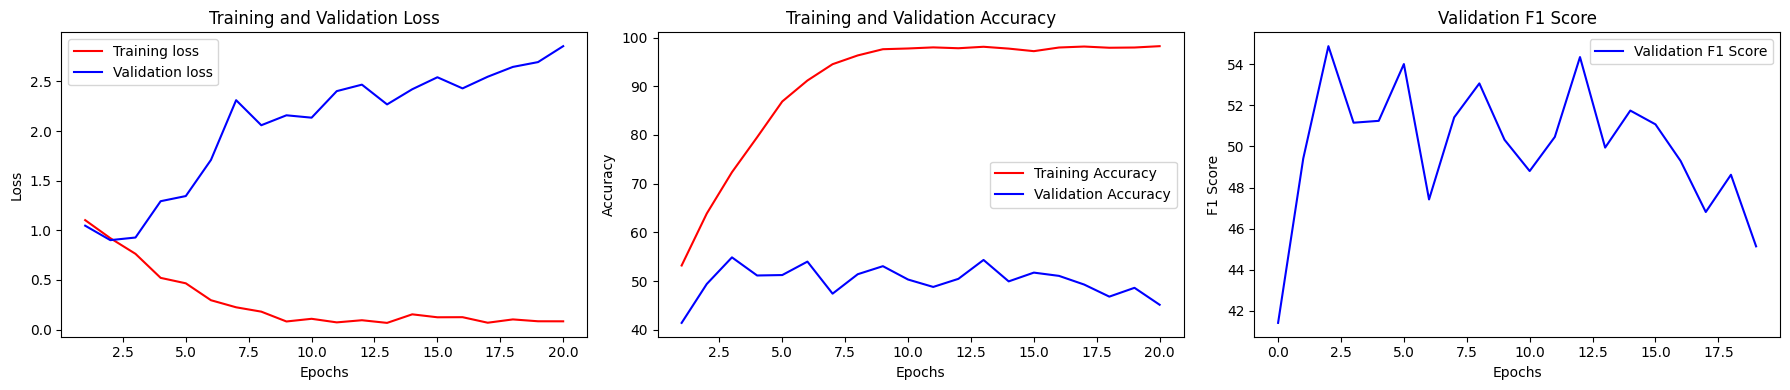

In [19]:
import matplotlib.pyplot as plt

epochs = range(1, config.num_train_epochs + 1)

plt.figure(figsize=(18, 4))  # 크기 조절

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, 'r', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# F1 Score plot 추가
plt.subplot(1, 3, 3)
plt.plot(val_f1_scores, 'b', label='Validation F1 Score')
plt.title('Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
from sklearn.metrics import accuracy_score, f1_score

# Load model weights
model.load_state_dict(torch.load(best_model_path))
model.to(devices[0])  # Move the model to GPU if necessary
model.eval()

all_predictions_2 = []
all_top2_predictions_2 = []
all_labels_2 = []

# Evaluate the test_dataset
with torch.no_grad():
    for inputs, labels in test_dataloader:
        for k, v in inputs.items():
            if isinstance(v, torch.Tensor):
                inputs[k] = v.to(devices[0])
        for k, v in labels.items():
            if isinstance(v, torch.Tensor):
                labels[k] = v.to(devices[0])

        outputs_2 = model(inputs)
        _, predicted_2 = outputs_2.topk(2, dim=1)

        all_predictions_2.extend(predicted_2[:, 0].cpu().tolist())
        all_top2_predictions_2.extend(predicted_2.cpu().tolist())
        all_labels_2.extend(labels["government"].cpu().tolist())

        # Print the actual values and predicted values
        for true_label_2, pred_label_2 in zip(labels["government"].cpu().tolist(), predicted_2[:, 0].cpu().tolist()):
            print(f"Output 2 - True Label: {true_label_2}, Predicted: {pred_label_2}")

# Calculate accuracy and f1-score
accuracy_2 = accuracy_score(all_labels_2, all_predictions_2)
f1_2 = f1_score(all_labels_2, all_predictions_2, average='macro')

# Calculate Top-2 Accuracy
top2_correct = sum([true_label in pred_labels for true_label, pred_labels in zip(all_labels_2, all_top2_predictions_2)])
top2_accuracy_2 = top2_correct / len(all_labels_2)

print(f"\nOutput 2 - Accuracy: {accuracy_2:.4f}, F1 Score: {f1_2:.4f}, Top-2 Accuracy: {top2_accuracy_2:.4f}")


Output 2 - True Label: 1, Predicted: 1
Output 2 - True Label: 0, Predicted: 0
Output 2 - True Label: 1, Predicted: 1
Output 2 - True Label: 1, Predicted: 2
Output 2 - True Label: 1, Predicted: 1
Output 2 - True Label: 1, Predicted: 2
Output 2 - True Label: 1, Predicted: 1
Output 2 - True Label: 2, Predicted: 1
Output 2 - True Label: 1, Predicted: 1
Output 2 - True Label: 0, Predicted: 1
Output 2 - True Label: 1, Predicted: 2
Output 2 - True Label: 1, Predicted: 1
Output 2 - True Label: 1, Predicted: 0
Output 2 - True Label: 1, Predicted: 2
Output 2 - True Label: 1, Predicted: 2
Output 2 - True Label: 1, Predicted: 2
Output 2 - True Label: 1, Predicted: 1
Output 2 - True Label: 1, Predicted: 1
Output 2 - True Label: 0, Predicted: 0
Output 2 - True Label: 2, Predicted: 0
Output 2 - True Label: 1, Predicted: 1
Output 2 - True Label: 2, Predicted: 2
Output 2 - True Label: 1, Predicted: 1
Output 2 - True Label: 2, Predicted: 1
Output 2 - True Label: 1, Predicted: 1
Output 2 - True Label: 0,